In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon, ttest_ind, mannwhitneyu,boxcox
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import statsmodels.api as sm
from pingouin import mixed_anova

PROJECTION_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"

csds = PROJECTION_PATH + "csds_fit_mean_scores.csv"
cms = PROJECTION_PATH + "CUS_mean_scores.csv"
cms_sp23 = PROJECTION_PATH + "Sp23_CMS_HC_mean_scores_corrected_chan_IDs.csv"
clock = PROJECTION_PATH + "net_{}_scores_headstage_tracked_CD19EPM_closed_arm_scores_over_time_w_HC_mean.csv"
clock_means = PROJECTION_PATH + "compheadstage_tracked_epm_mean_scores.csv"
mouse_sexes = "/hpc/home/mk423/Anxiety/FullDataWork/Preprocessing/CLOCK_mice_sexes.xlsx"

csds_control_mice = [
    'Mouse3203','Mouse3205','Mouse3215','Mouse3221','Mouse3223','Mouse3231',
    'Mouse3235','Mouse3252','Mouse1381','Mouse1393','Mouse1403','Mouse1412','Mouse7181',
    'Mouse7185','Mouse7191','Mouse7222'
]

csds_resilient_mice = [
    'Mouse3211','Mouse3212','Mouse3213','Mouse3214','Mouse1382','Mouse1392',
    'Mouse1402','Mouse1404','Mouse1405','Mouse1413','Mouse7182','Mouse7192',
    'Mouse7221'
]

csds_susceptible_mice = ['Mouse3201','Mouse3202','Mouse3204','Mouse3224','Mouse3233','Mouse3234',
    'Mouse3251','Mouse3253','Mouse1383','Mouse1384','Mouse1391','Mouse1401',
    'Mouse1411','Mouse7183','Mouse7184','Mouse7193','Mouse7194','Mouse7195',
    'Mouse7202','Mouse7203','Mouse7204'
]

sp23_include_mice = [26352,
26354,
26361,
26362,
26363,
26364,
26371,
26374,
26382,
26384,
26385,
26391,
26392,
26393,
26394,]

def reshape_df(df,data_idxs,group):
    mice = df.mouse
    new_structure = np.zeros((len(data_idxs)*len(mice),4))*np.nan
    for idx, mouse in enumerate(mice):
        new_structure[(len(data_idxs)*idx):(len(data_idxs)*(idx+1)),0] = df[data_idxs].values[idx,:].copy()
        new_structure[(len(data_idxs)*idx):(len(data_idxs)*(idx+1)),1] = idx + 1
        new_structure[(len(data_idxs)*idx):(len(data_idxs)*(idx+1)),2] = data_idxs
        new_structure[(len(data_idxs)*idx):(len(data_idxs)*(idx+1)),3] = group
    return pd.DataFrame(new_structure,columns=["score","mouse","time","geno"])

## CLOCK D19

#### Behavior

Ttest_indResult(statistic=-2.901357840619022, pvalue=0.003335302132313427)


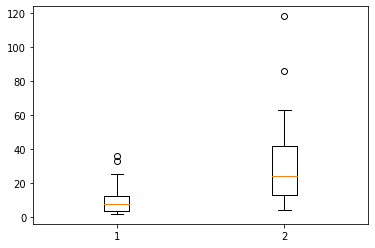

In [39]:
WT_OA_Time = [
    3.38, 2.33, 25.18, 9.65, 2.33, 35.63, 10.08, 
    7.73, 3.98, 32.75, 23.93, 3.58, 4.70, 5.80, 
    1.68, 12.38, 7.33
]

CLOCK_OA_Time = [
    13.45, 62.80, 118.08, 37.10, 41.63, 28.45, 22.68,
    85.78, 36.98, 11.57, 5.98, 4.08, 7.38, 12.58,
    16.70, 24.05, 59.70
]
              
print(ttest_ind(WT_OA_Time,CLOCK_OA_Time,alternative="less"))

plt.boxplot([WT_OA_Time,CLOCK_OA_Time])
plt.show()

#### Exposure to Elevated Plus Maze

In [7]:
df = pd.read_csv(clock_means)
clock_mask = df.condition=="CLOCK"
wt_mask = df.condition=="WT"

In [20]:
n1_scores = np.hstack([df["net 1 avgHCScore"].values,df["net 1 avgTaskScore"].values])
n2_scores = np.hstack([df["net 2 avgHCScore"].values,df["net 2 avgTaskScore"].values])
genotype = np.hstack([df["condition"].values=="WT",df["condition"].values=="WT"])
inTask = np.hstack([[0 for _ in range(df.shape[0])],[1 for _ in range(df.shape[0])]])
mouse_id = np.hstack([[i+1 for i in range(df.shape[0])],[i+1 for i in range(df.shape[0])]])

stats_df = pd.DataFrame.from_dict({
    "n1_scores":boxcox(20*n1_scores)[0],
    "n2_scores":boxcox(20*n2_scores)[0],
    "genotype":genotype,
    "inTask":inTask,
    "mouse_id":mouse_id,
})

print("Network 1: ")
aov = mixed_anova(dv='n1_scores', between='genotype',
                  within='inTask', subject='mouse_id', data=stats_df)
aov

Network 1: 


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,genotype,0.379909,1,19,0.379909,1.046070,0.319261,0.052183,NaN
1,inTask,0.705187,1,19,0.705187,15.812974,0.000808,0.454226,1.0
2,Interaction,0.014173,1,19,0.014173,0.317811,0.579520,0.016452,NaN


In [21]:
print("Network 2: ")
aov = mixed_anova(dv='n2_scores', between='genotype',
                  within='inTask', subject='mouse_id', data=stats_df)
aov

Network 2: 


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,genotype,1.711045,1,19,1.711045,2.015247,0.171925,0.095895,NaN
1,inTask,3.253328,1,19,3.253328,17.177366,0.000551,0.474810,1.0
2,Interaction,0.109142,1,19,0.109142,0.576264,0.457096,0.029437,NaN


In [22]:
print("WT Network 1 HC vs. Task: ",
      wilcoxon(df[wt_mask==1]["net 1 avgHCScore"],
               df[wt_mask==1]["net 1 avgTaskScore"],
               alternative="less"))

print("WT Network 2 HC vs. Task: ",
      wilcoxon(df[wt_mask==1]["net 2 avgHCScore"],
               df[wt_mask==1]["net 2 avgTaskScore"],
               alternative="less"))

print("\n\nCLOCK Network 1 HC vs. Task: ",
      wilcoxon(df[clock_mask==1]["net 1 avgHCScore"],
               df[clock_mask==1]["net 1 avgTaskScore"],
               alternative="less"))

print("CLOCK Network 2 HC vs. Task: ",
      wilcoxon(df[clock_mask==1]["net 2 avgHCScore"],
               df[clock_mask==1]["net 2 avgTaskScore"],
               alternative="less"))



WT Network 1 HC vs. Task:  WilcoxonResult(statistic=2.0, pvalue=0.0029296875)
WT Network 2 HC vs. Task:  WilcoxonResult(statistic=4.0, pvalue=0.0068359375)


CLOCK Network 1 HC vs. Task:  WilcoxonResult(statistic=10.0, pvalue=0.02099609375)
CLOCK Network 2 HC vs. Task:  WilcoxonResult(statistic=9.0, pvalue=0.01611328125)




-------NETWORK 1-------




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


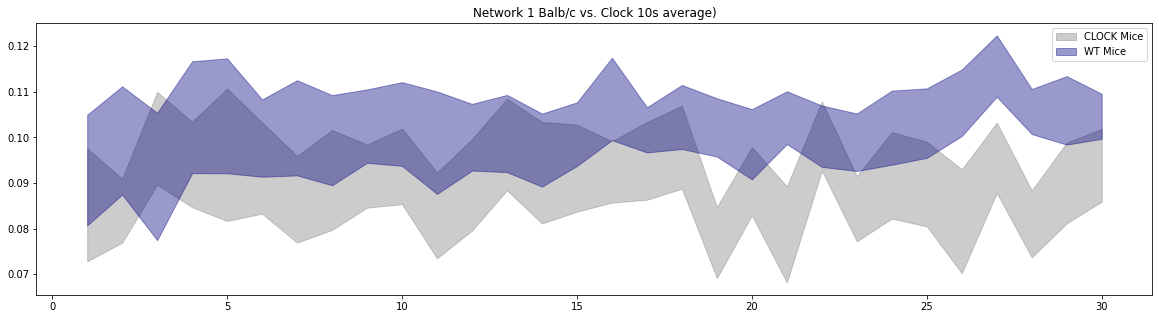



JOINT MODEL MICE NETWORK 1 ANCOVA scores ~ geno + time


                            OLS Regression Results                            
Dep. Variable:                 scores   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     60.50
Date:                Tue, 25 Jun 2024   Prob (F-statistic):           1.55e-26
Time:                        08:39:17   Log-Likelihood:                 6389.4
No. Observations:                3354   AIC:                        -1.277e+04
Df Residuals:                    3351   BIC:                        -1.275e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


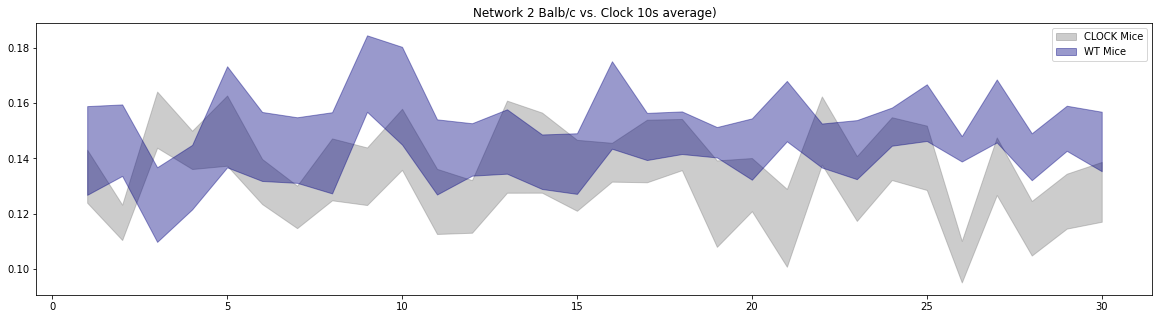



JOINT MODEL MICE NETWORK 2 ANCOVA scores ~ geno + time


                            OLS Regression Results                            
Dep. Variable:                 scores   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     27.98
Date:                Tue, 25 Jun 2024   Prob (F-statistic):           8.91e-13
Time:                        08:39:17   Log-Likelihood:                 4775.4
No. Observations:                3354   AIC:                            -9545.
Df Residuals:                    3351   BIC:                            -9526.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [4]:
def gad(df,idxs,num_secs=10):
    return np.nanmean(df[idxs].values.reshape(df.shape[0],-1,num_secs),axis=2)

df_sex = pd.read_excel(mouse_sexes,header=None)

clock_mice = df_sex[df_sex[1]=="CLOCK"][0].values
wt_mice = df_sex[df_sex[1]=="WT"][0].values

networks = [1,2]
all_idxs = np.arange(1,301).astype(str)

for net in networks:
    
    print("\n\n-------NETWORK {}-------\n\n".format(net))
    ca_data = pd.read_csv(clock.format(net))
    
    ca_clock = pd.concat([ca_data[ca_data.mouse==mouse] for mouse in clock_mice])
    ca_wt = pd.concat([ca_data[ca_data.mouse==mouse] for mouse in wt_mice])
    
    plt.figure(figsize=(20,5))
    
    clock_minute_averaged = gad(ca_clock,all_idxs)
    wt_minute_averaged = gad(ca_wt,all_idxs)
    
    plt.fill_between(np.arange(1,clock_minute_averaged.shape[1]+1),
                     np.nanmean(clock_minute_averaged,axis=0) + np.nanstd(clock_minute_averaged,axis=0)/np.sqrt(clock_mice.shape[0]),
                     np.nanmean(clock_minute_averaged,axis=0) - np.nanstd(clock_minute_averaged,axis=0)/np.sqrt(clock_mice.shape[0]),
                     color="grey",
                     alpha=0.4,
                     label="CLOCK Mice"
                    )
    plt.fill_between(np.arange(1,wt_minute_averaged.shape[1]+1),
                     np.nanmean(wt_minute_averaged,axis=0) + np.nanstd(wt_minute_averaged,axis=0)/np.sqrt(wt_mice.shape[0]),
                     np.nanmean(wt_minute_averaged,axis=0) - np.nanstd(wt_minute_averaged,axis=0)/np.sqrt(wt_mice.shape[0]),
                     color="navy",
                     alpha=0.4,
                     label="WT Mice"
                    )
    plt.legend()
    plt.title("Network {} Balb/c vs. Clock 10s average)".format(net))
    plt.show()
    
    full_df = {}
    full_df["mouse"] = []
    full_df["geno"] = []
    full_df["sex"] = []
    full_df["time"] = []
    full_df["scores"] = []

    for idx, mouse in enumerate(ca_data.mouse.values):
        sex = df_sex[df_sex[0]==mouse][2]
        geno = df_sex[df_sex[0]==mouse][1]
        full_df["mouse"].append([idx+1]*300)
        full_df["sex"].append([sex=="F"]*300)
        full_df["geno"].append([geno=="WT"]*300)
        full_df["time"].append(np.arange(1,301))
        full_df["scores"].append(ca_data[ca_data.mouse==mouse][np.arange(1,301).astype(str)])

    full_df["mouse"] = np.array(full_df["mouse"]).reshape(-1)
    full_df["geno"] = np.array(full_df["geno"]).reshape(-1)
    full_df["sex"] = np.array(full_df["sex"]).reshape(-1)
    full_df["time"] = np.array(full_df["time"]).reshape(-1)
    full_df["scores"] = np.array(full_df["scores"]).reshape(-1)

    df_stats_full = pd.DataFrame.from_dict(full_df)
    
    formula = "scores ~ geno + time"
    model = ols(formula,data=df_stats_full).fit()
    print("\n\nJOINT MODEL MICE NETWORK {} ANCOVA ".format(net) + formula + "\n\n")
    print(model.summary())

## CSDS

#### Behavior

All Together:  Ttest_indResult(statistic=2.278121938635819, pvalue=0.019588690049136465)
Sus vs Res:  Ttest_indResult(statistic=-0.1622084430312658, pvalue=0.874990294868778)


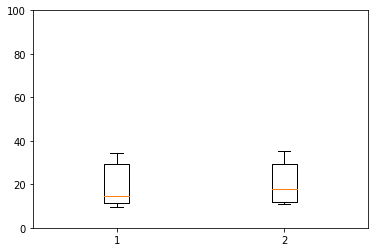

In [31]:
oa_time_controls = [31.233,
16.8998,
72.1659,
22.2331,
36.333,
47.7995,
40.9996,
14.1665,
46.7995,
20.9331]

oa_time_treatment = [14.6332,
34.3663,
9.63324,
29.1997,
11.3999,
33.2997,
24.9997,
10.8666,
35.3663,
12.5999,
11.0332,
17.9998]

result = ttest_ind(oa_time_controls,oa_time_treatment,equal_var=False,alternative="greater")
print("All Together: ",result)

susceptible = [14.6332, 34.3663, 9.63324, 29.1997, 11.3999]
resilient = [33.2997, 24.9997, 10.8666, 35.3663, 12.5999, 
             11.0332, 17.9998]

result = ttest_ind(susceptible,resilient,equal_var=False,alternative="two-sided")
print("Sus vs Res: ", result)

plt.boxplot([susceptible,resilient])
plt.ylim([0,100])
plt.show()

#### Homecage Stress vs Controls (Resilient vs Susceptible)

In [21]:
df = pd.read_csv(csds)

df_hc = df[["mouse","interval 1 mean net 1 score","interval 1 mean net 2 score"]]
df_controls = df_hc[df_hc.mouse.isin(csds_control_mice)]
df_res = df_hc[df_hc.mouse.isin(csds_resilient_mice)]
df_sus = df_hc[df_hc.mouse.isin(csds_susceptible_mice)]

Net 1 Controls vs. Stressed :  MannwhitneyuResult(statistic=332.0, pvalue=0.895846451570331)
Net 1 Susceptible vs. Resilient :  MannwhitneyuResult(statistic=135.0, pvalue=0.9717300889311167)


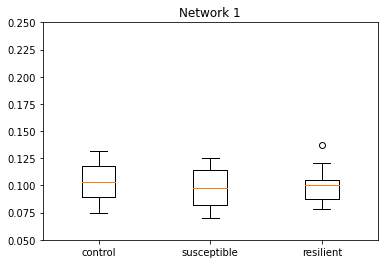

Net 2 Controls vs. Stressed :  MannwhitneyuResult(statistic=159.0, pvalue=0.009649835802987217)
Net 2 Susceptible vs. Resilient :  MannwhitneyuResult(statistic=151.0, pvalue=0.619796388494133)


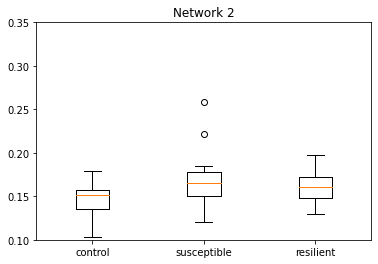

In [32]:
print("Net 1 Controls vs. Stressed : ",mannwhitneyu(df_controls["interval 1 mean net 1 score"],
                                              np.hstack([df_sus["interval 1 mean net 1 score"],
                                                         df_res["interval 1 mean net 1 score"]]),
                                              alternative="less"))

print("Net 1 Susceptible vs. Resilient : ",mannwhitneyu(df_sus["interval 1 mean net 1 score"],
                                                  df_res["interval 1 mean net 1 score"]))
      
plt.boxplot([df_controls["interval 1 mean net 1 score"],
             df_sus["interval 1 mean net 1 score"],
             df_res["interval 1 mean net 1 score"]])
plt.ylim([0.05,0.25])
plt.xticks([1,2,3],["control","susceptible","resilient"])
plt.title("Network 1")
plt.show()


print("Net 2 Controls vs. Stressed : ",mannwhitneyu(df_controls["interval 1 mean net 2 score"],
                                              np.hstack([df_sus["interval 1 mean net 2 score"],
                                                         df_res["interval 1 mean net 2 score"]]),
                                              alternative="less"))

print("Net 2 Susceptible vs. Resilient : ",mannwhitneyu(df_sus["interval 1 mean net 2 score"],
                                                  df_res["interval 1 mean net 2 score"]))
      
plt.boxplot([df_controls["interval 1 mean net 2 score"],
             df_sus["interval 1 mean net 2 score"],
             df_res["interval 1 mean net 2 score"]])
plt.ylim([0.10,0.35])
plt.xticks([1,2,3],["control","susceptible","resilient"])
plt.title("Network 2")
plt.show()

### CMS

#### Behavior

In [34]:
S_OA_time = [
    47.72,
    47.22,
    31.9,
    8.22,
    18.24,
    13,
    41.1767,
    52.7814,
    58.1029,
    49.8192,
    38.1349,
]

C_OA_time = [
    47.56,
    50.82,
    148.46,
    100.48,
    94.3,
    122.7,
    102.121,
    40.939,
    23.2894,
    6.12242
]


print("Control Std: {:.2f} Stressed Std: {:.2f}".format(np.std(C_OA_time),np.std(S_OA_time)))
result = ttest_ind(C_OA_time,S_OA_time,equal_var=False,alternative="greater")
print(result)

Control Std: 43.96 Stressed Std: 16.18
Ttest_indResult(statistic=2.367110744009409, pvalue=0.018502637335128625)


## Dropping Mice that were misimplanted

In [35]:
stressed = [
    0.07407721, 0.0660719, 0.09233438, 0.0952514, 0.08015043, 0.10543811,
    0.09013793, 0.04838003, 0.06919497, 0.06791833, 0.06968681
]

control = [
    0.06334403, 0.09205309, 0.04660195, 0.07462807, 0.041973677, 0.057892665,
    0.06590251, 0.0739319, 0.073364735, 0.06042923
]

mannwhitneyu(stressed,control,alternative="greater")

MannwhitneyuResult(statistic=82.0, pvalue=0.031015520907682056)

In [36]:
stressed = [
    0.17151186, 0.12722774, 0.1041459, 0.13213436, 0.1466029, 0.121950425,
    0.14501671, 0.15826087, 0.17050335, 0.14583272, 0.12167237
]

control = [
    0.17239141, 0.10769659, 0.065067746, 0.12491463, 0.041578718, 0.109278575,
    0.15071374, 0.0873157, 0.14140996, 0.09672972
]

mannwhitneyu(stressed,control,alternative="greater")

MannwhitneyuResult(statistic=81.0, pvalue=0.03627462861024203)